# Zero-shot classification using CLIP

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Some Installations

In [2]:
!pip install clip-openai
!pip install seaborn

# Some imports

In [3]:
import torch
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import (
    Resize, Compose, ToTensor, Normalize, CenterCrop, RandomResizedCrop,
    RandomHorizontalFlip, ColorJitter
)
from torchvision.transforms.functional import InterpolationMode
import clip

# Load the model

In [4]:
### Get Model
backbone = 'ViT-B/16'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model, transform = clip.load(backbone, device=device, jit=False)
model = model.float()
_ = model.eval()

### Define transforms
def get_transforms():
    size = (224,224)
    # Mode of interpolation in resize functions
    INTERPOLATION = InterpolationMode.BICUBIC
    # Mean and std (default: CoOp)
    PIXEL_MEAN = [0.48145466, 0.4578275, 0.40821073]
    PIXEL_STD = [0.26862954, 0.26130258, 0.27577711]
    normalize = Normalize(mean=PIXEL_MEAN, std=PIXEL_STD)
    RRCROP_SCALE = (0.08, 1.0)
    transform = Compose([
        Resize(size=max(size), interpolation=INTERPOLATION),
        CenterCrop(size=size),
        ToTensor(),
        normalize,
    ])
    return transform

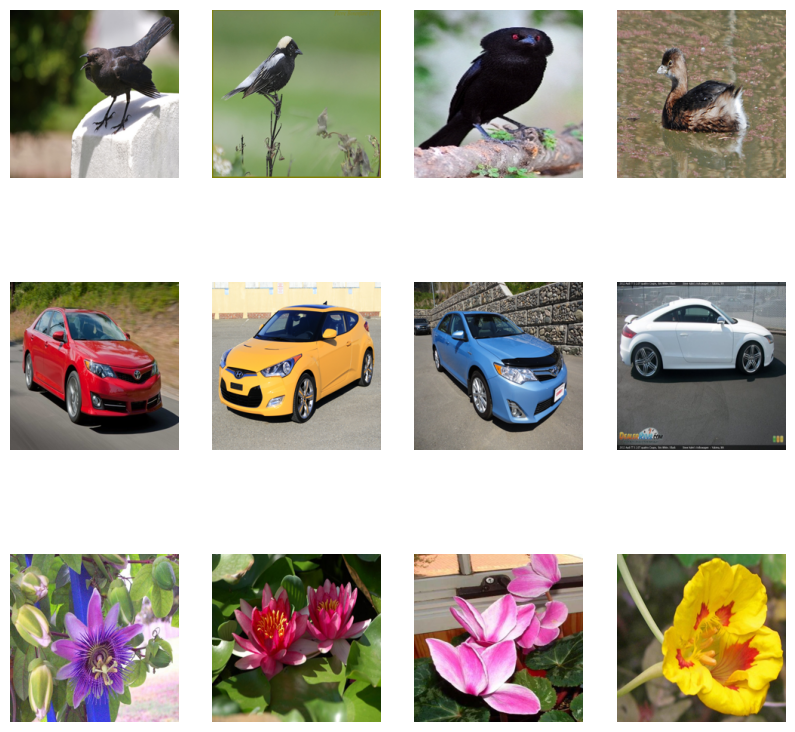

In [5]:
################ ################ ################ ################
#                              Images
################ ################ ################ ################
# load images
FOLDER_PATH = './images'
images, labels = [], []

for c, classe in enumerate(sorted(os.listdir(FOLDER_PATH))):
    files = [Image.open(os.path.join(FOLDER_PATH, classe, file)) for file in sorted(os.listdir(os.path.join(FOLDER_PATH, classe))) if '.jpg' in file]
    images += files
    labels += [c]*len(files)
    
labels = torch.tensor(labels)
# visualize grid of images
nb_classes = len(torch.unique(labels))
SIZE = 4

fig, axes = plt.subplots(nb_classes, SIZE, figsize=(10,10))
for c in range(nb_classes):
    images_idx = torch.where(labels==c)[0][:SIZE]
    for j in range(SIZE):
        axes[c,j].imshow(images[images_idx[j].item()].resize((224, 224)))
        axes[c,j].set_axis_off()
plt.axis('off')
plt.show()

# Generate embeddings of the images 

In [6]:
def embed_images(model, images):
    transform = get_transforms()
    transformed_images = torch.stack([transform(im) for im in images])
    with torch.no_grad():
        image_features = model.encode_image(transformed_images.to(device)) # Forward the images through the image encoder
    return image_features.cpu()

image_features = embed_images(model, images)
print(image_features.shape)

torch.Size([12, 512])


# Generate embeddings of the text 

In [7]:
def embed_text(model, str_prompts):
    prompts = torch.cat([clip.tokenize(str_prompts[i]) for i in range(len(str_prompts))]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(prompts.to(device)) # Forward the text through the text encoder
    return text_features.cpu()

# Image Retrieval

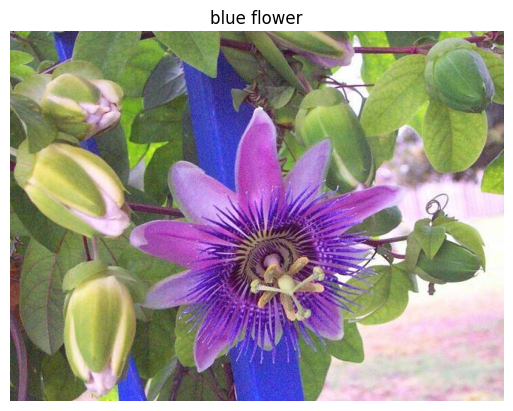

In [8]:
#### retrieval:
import torch.nn.functional as F

def retrieve(prompt, model, image_features):
    """
        Given a prompt, retrieve the image with the highest cosine similarity
    """
    text_feature = embed_text(model, [prompt]).squeeze(0)
    # Compute the cosine similarity 
    cosine_similarities = torch.einsum('nd,d->n', F.normalize(image_features, dim=1), F.normalize(text_feature, dim=0))
    return cosine_similarities.argmax().item()

prompt = 'blue flower'
fig, ax = plt.subplots()
idx = retrieve(prompt, model, image_features)
image = images[idx]
plt.imshow(image)
plt.title(prompt)
plt.axis('off')
plt.show()

# Zero-shot Classification

## Define a pool of class candidates

In [9]:
template = 'A photo of {}.'
classes = ['bird', 'car', 'flower']
str_prompts = [template.format(text) for i,text in enumerate(classes)]
print(str_prompts)
text_features = embed_text(model, classes)
print(text_features.shape)

['A photo of bird.', 'A photo of car.', 'A photo of flower.']
torch.Size([3, 512])


## Compute cosine similarity between text and images

In [10]:
cosine_similarities = torch.einsum('nd,cd->nc', F.normalize(image_features, dim=1), F.normalize(text_features, dim=1))
predictions = cosine_similarities.argmax(dim=1)

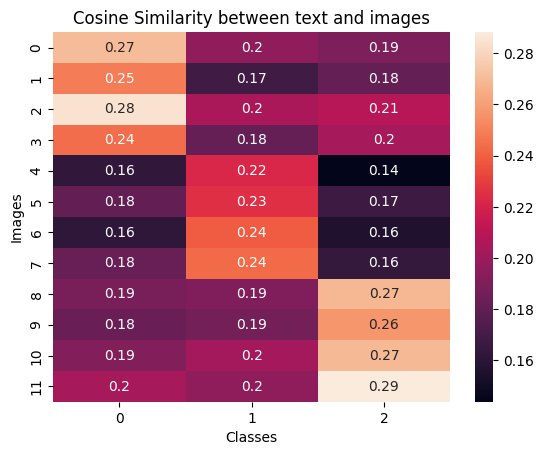

In [11]:
import seaborn as sns
fig, ax = plt.subplots()
sns.heatmap(cosine_similarities, annot=True, ax=ax)
plt.xlabel('Classes')
plt.ylabel('Images')
plt.title('Cosine Similarity between text and images')
plt.show()

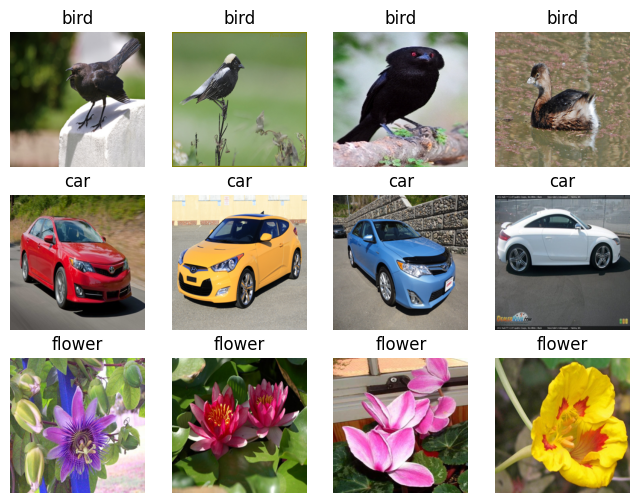

In [12]:
fig, axes = plt.subplots(3,4, figsize=(8,6))
c = 0
for i in range(3):
    for j in range(4):
        axes[i,j].imshow(images[c].resize((224, 224)))
        axes[i,j].set_axis_off()
        axes[i,j].set_title(classes[predictions[c].item()])
        c+=1
plt.axis('off')
plt.show()

## Let's change the class names

In [13]:
def predict(classes):
    str_prompts = [template.format(text) for i,text in enumerate(classes)]
    print(str_prompts)
    text_features = embed_text(model, classes)

    # Compute cosine similarity between text and images
    cosine_similarities = torch.einsum('nd,cd->nc', F.normalize(image_features, dim=1), F.normalize(text_features, dim=1))
    predictions = cosine_similarities.argmax(dim=1)
    fig, axes = plt.subplots(3,4, figsize=(8,6))
    c = 0
    images_idx = torch.cat([torch.where(predictions==c)[0] for c in range(len(classes))])
    for i in range(3):
        for j in range(4):
            axes[i,j].imshow(images[images_idx[c].item()].resize((224, 224)))
            axes[i,j].set_axis_off()
            axes[i,j].set_title(classes[predictions[images_idx[c].item()].item()])
            c+=1
    plt.axis('off')
    plt.show()
    return predictions 

['A photo of blue.', 'A photo of red.', 'A photo of white.']


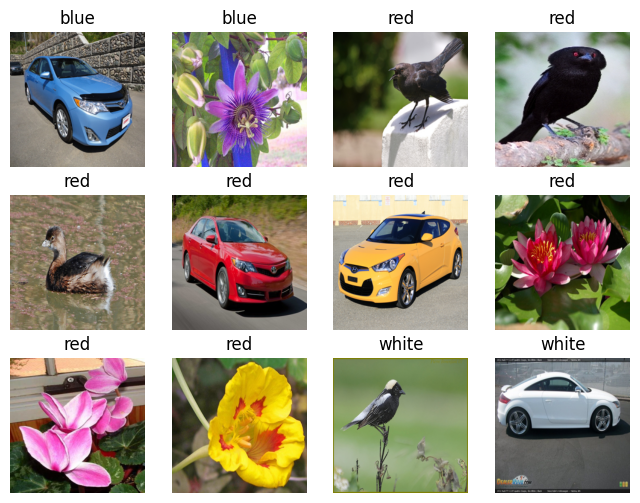

In [14]:
classes = ['blue', 'red', 'white']
_ = predict(classes)

# Visualization of classifications

In [15]:
# Project the feature images on the axes between the text prototypes
def reduce_dimension(text_features, image_features):
    """
        Perfom QR decomposition on features
        - In:
        - Out:
    """
    # Compute the centroids of each class

    # Get Two directions of the centroids.
    perm = torch.arange(text_features.shape[0])-1
    directions = (text_features-text_features[perm])[:-1]

    # Get the QR decomposition from the directions of the centroids
    Q, R = torch.linalg.qr(directions.T)
    # Project Q on the data
    reduced_text_features = torch.matmul(text_features, Q)
    reduced_image_features = torch.matmul(image_features, Q)
    return reduced_text_features, reduced_image_features

torch.Size([3, 512])
['A photo of car.', 'A photo of bird.', 'A photo of flower.']


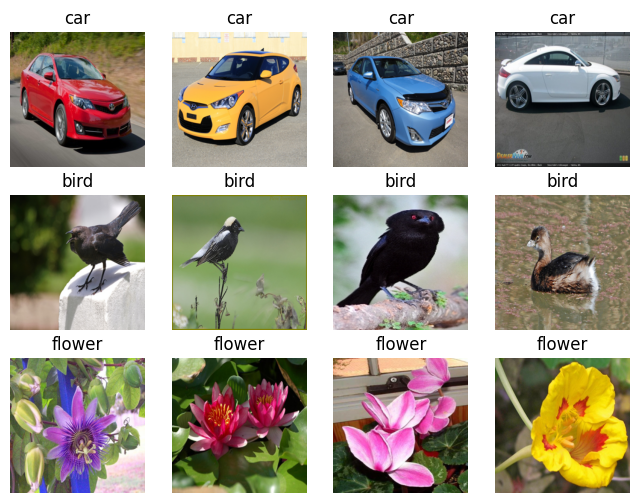

In [16]:
template = 'A photo of {}.'
classes = ['car', 'bird', 'flower']
str_prompts = [template.format(text) for i,text in enumerate(classes)]
text_features = embed_text(model, classes)
print(text_features.shape)
predictions = predict(classes)

In [17]:
reduced_text_features, reduced_image_features = reduce_dimension(F.normalize(text_features, dim=1), F.normalize(image_features, dim=1))
reduced_image_features_reshaped = [reduced_image_features[predictions==l] for l in torch.unique(predictions)]
images_reshaped = [[images[pred.item()] for pred in torch.where(predictions==l)[0]] for l in torch.unique(predictions)]

In [18]:
from utils import hover_few_shot_space

<IPython.core.display.Javascript object>


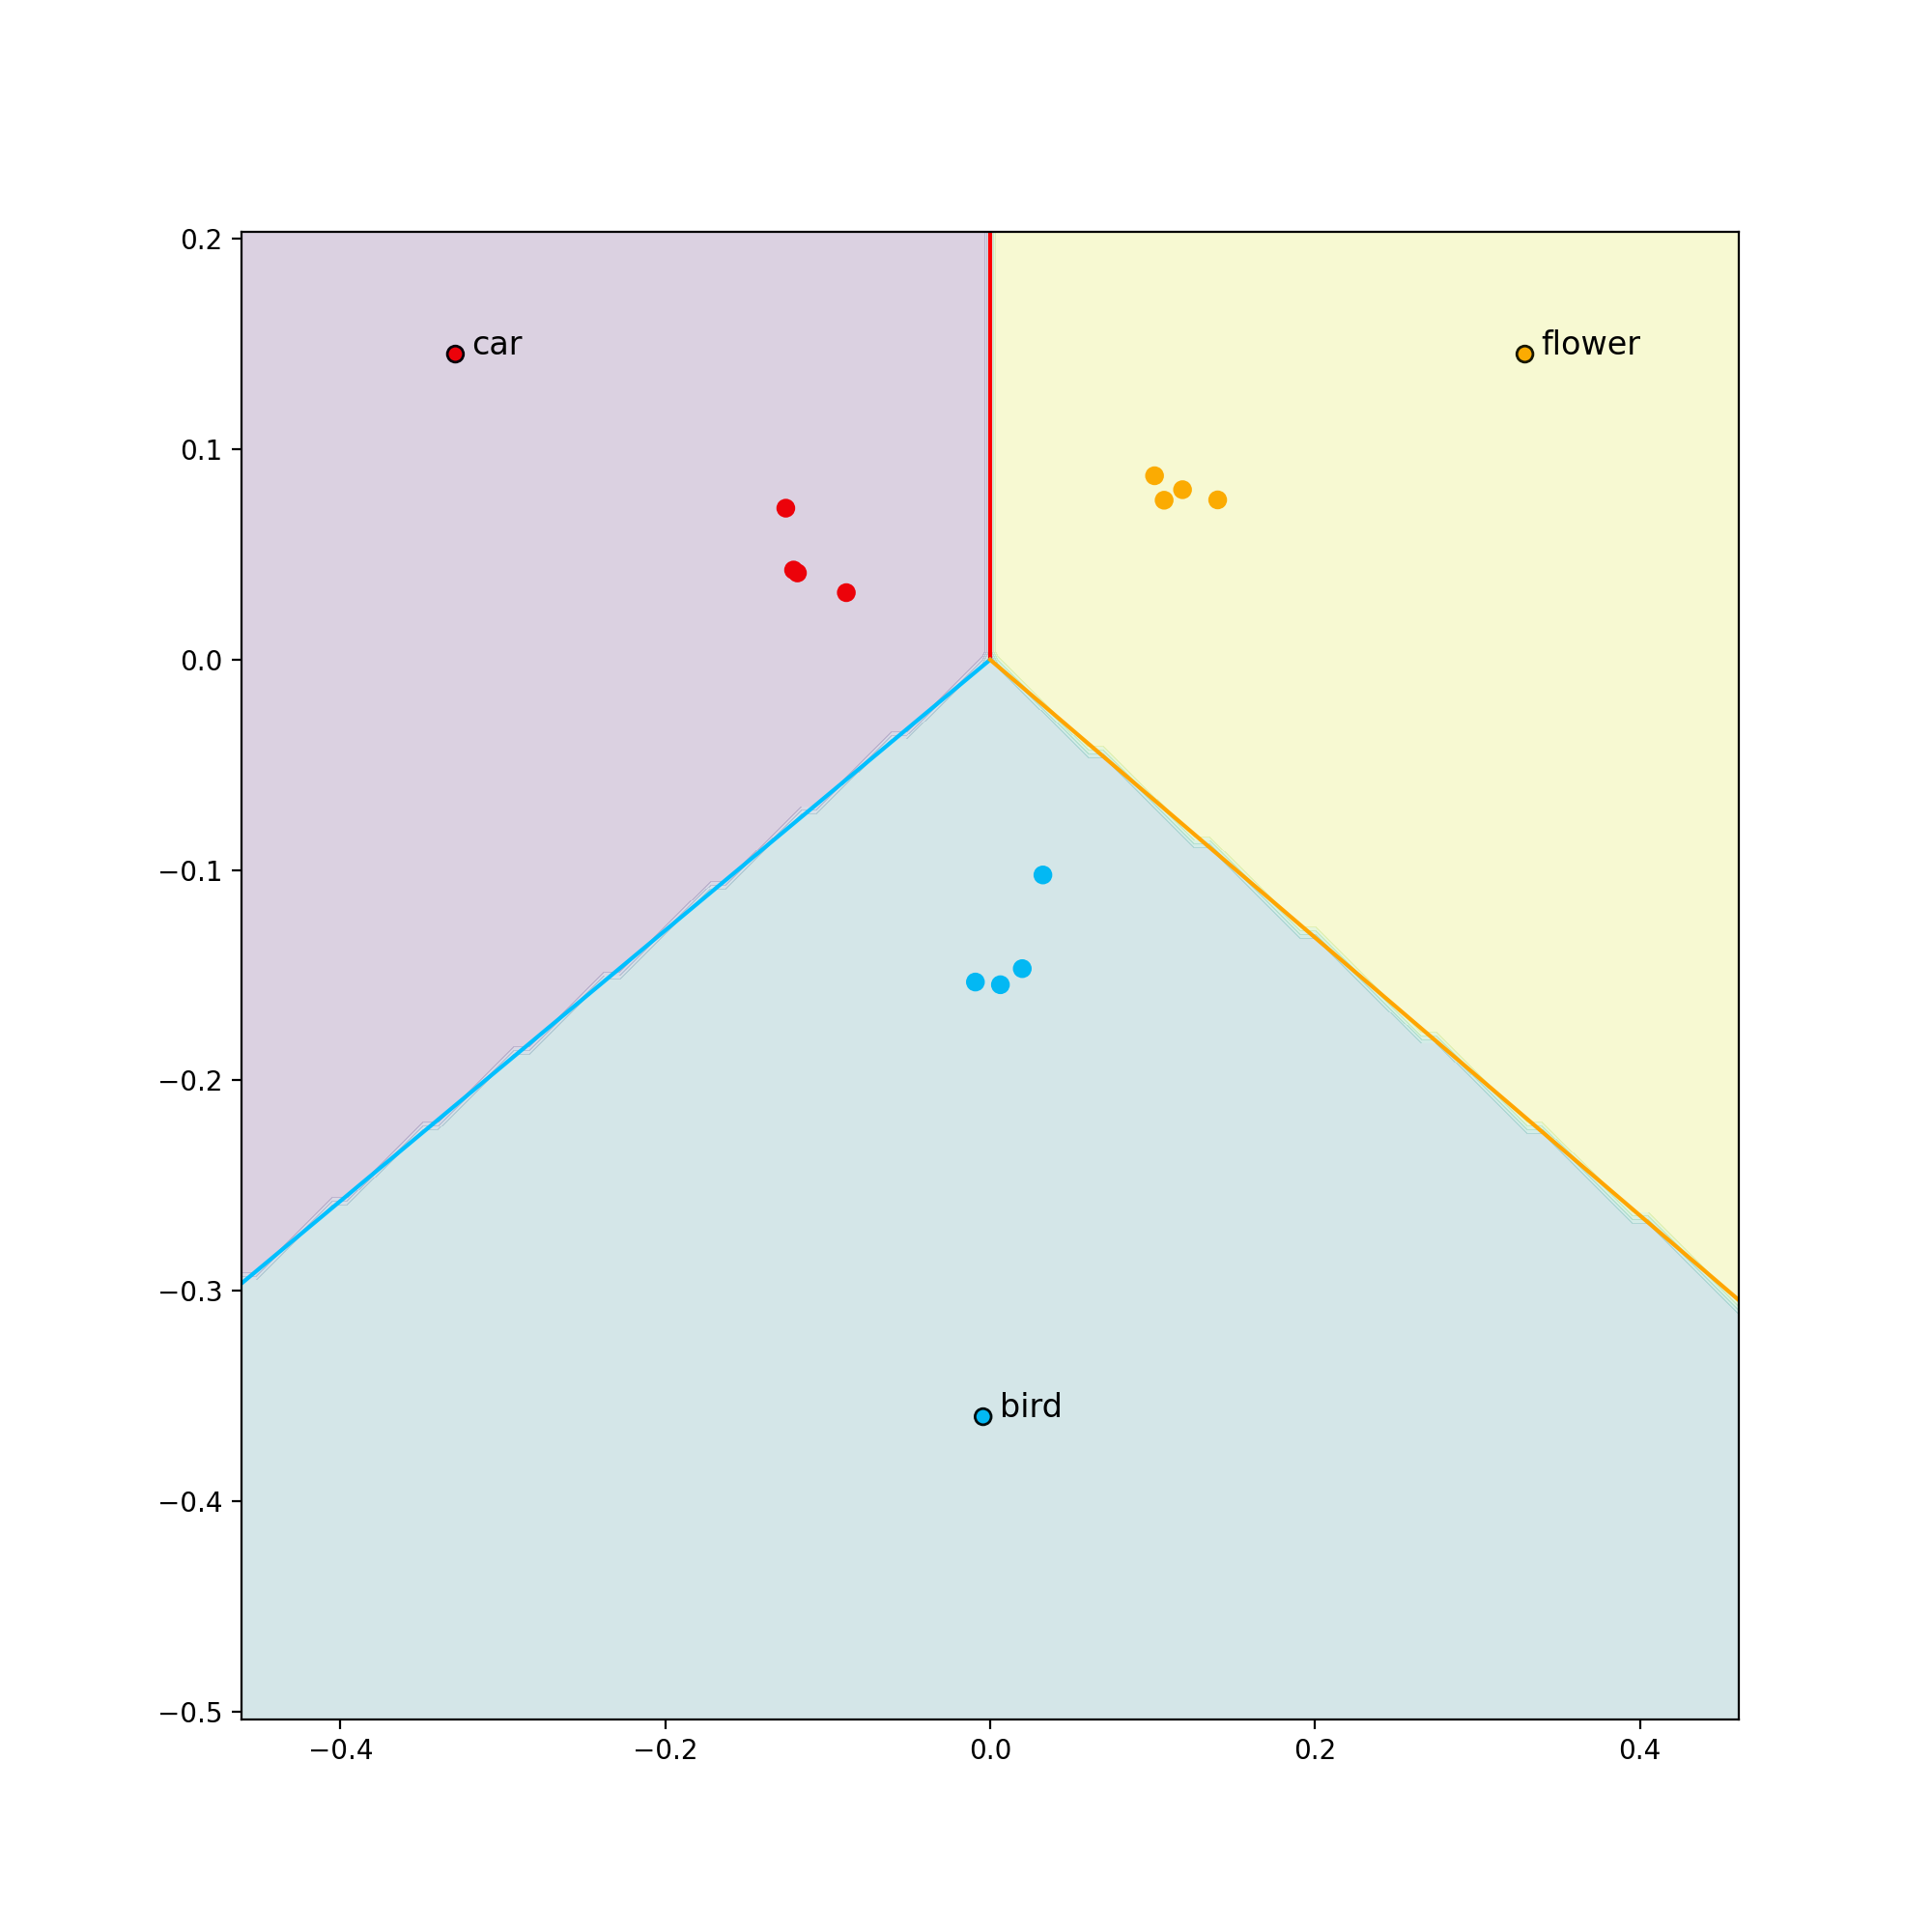

In [19]:
%matplotlib notebook
hover_few_shot_space(reduced_text_features, reduced_image_features_reshaped, images_reshaped, classes,  figsize=(10, 10))

torch.Size([3, 512])
['A photo of red.', 'A photo of blue.', 'A photo of yellow.']


<IPython.core.display.Javascript object>


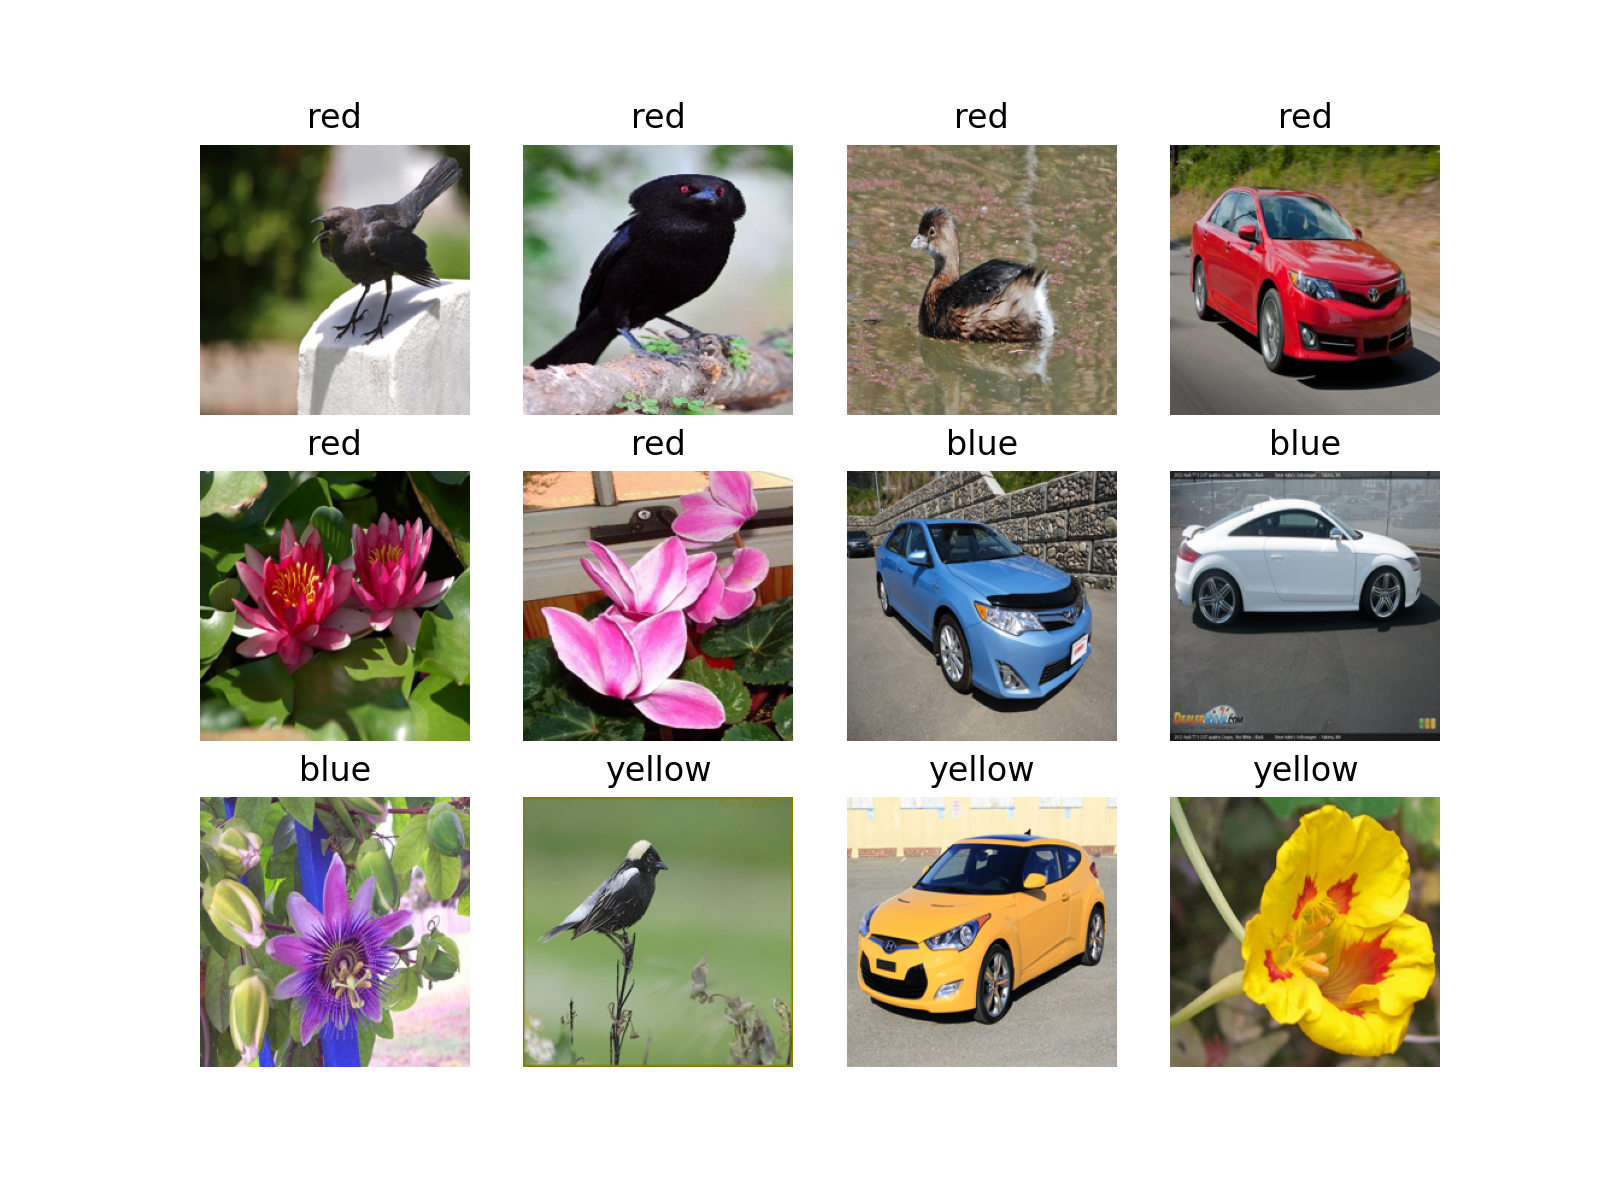

In [20]:
template = 'A photo of {}.'
classes = ['red', 'blue', 'yellow']
str_prompts = [template.format(text) for i,text in enumerate(classes)]
text_features = embed_text(model, classes)
print(text_features.shape)
predictions = predict(classes)

In [21]:
reduced_text_features, reduced_image_features = reduce_dimension(F.normalize(text_features, dim=1), F.normalize(image_features, dim=1))
reduced_image_features_reshaped = [reduced_image_features[predictions==l] for l in torch.unique(predictions)]
images_reshaped = [[images[pred.item()] for pred in torch.where(predictions==l)[0]] for l in torch.unique(predictions)]

<IPython.core.display.Javascript object>


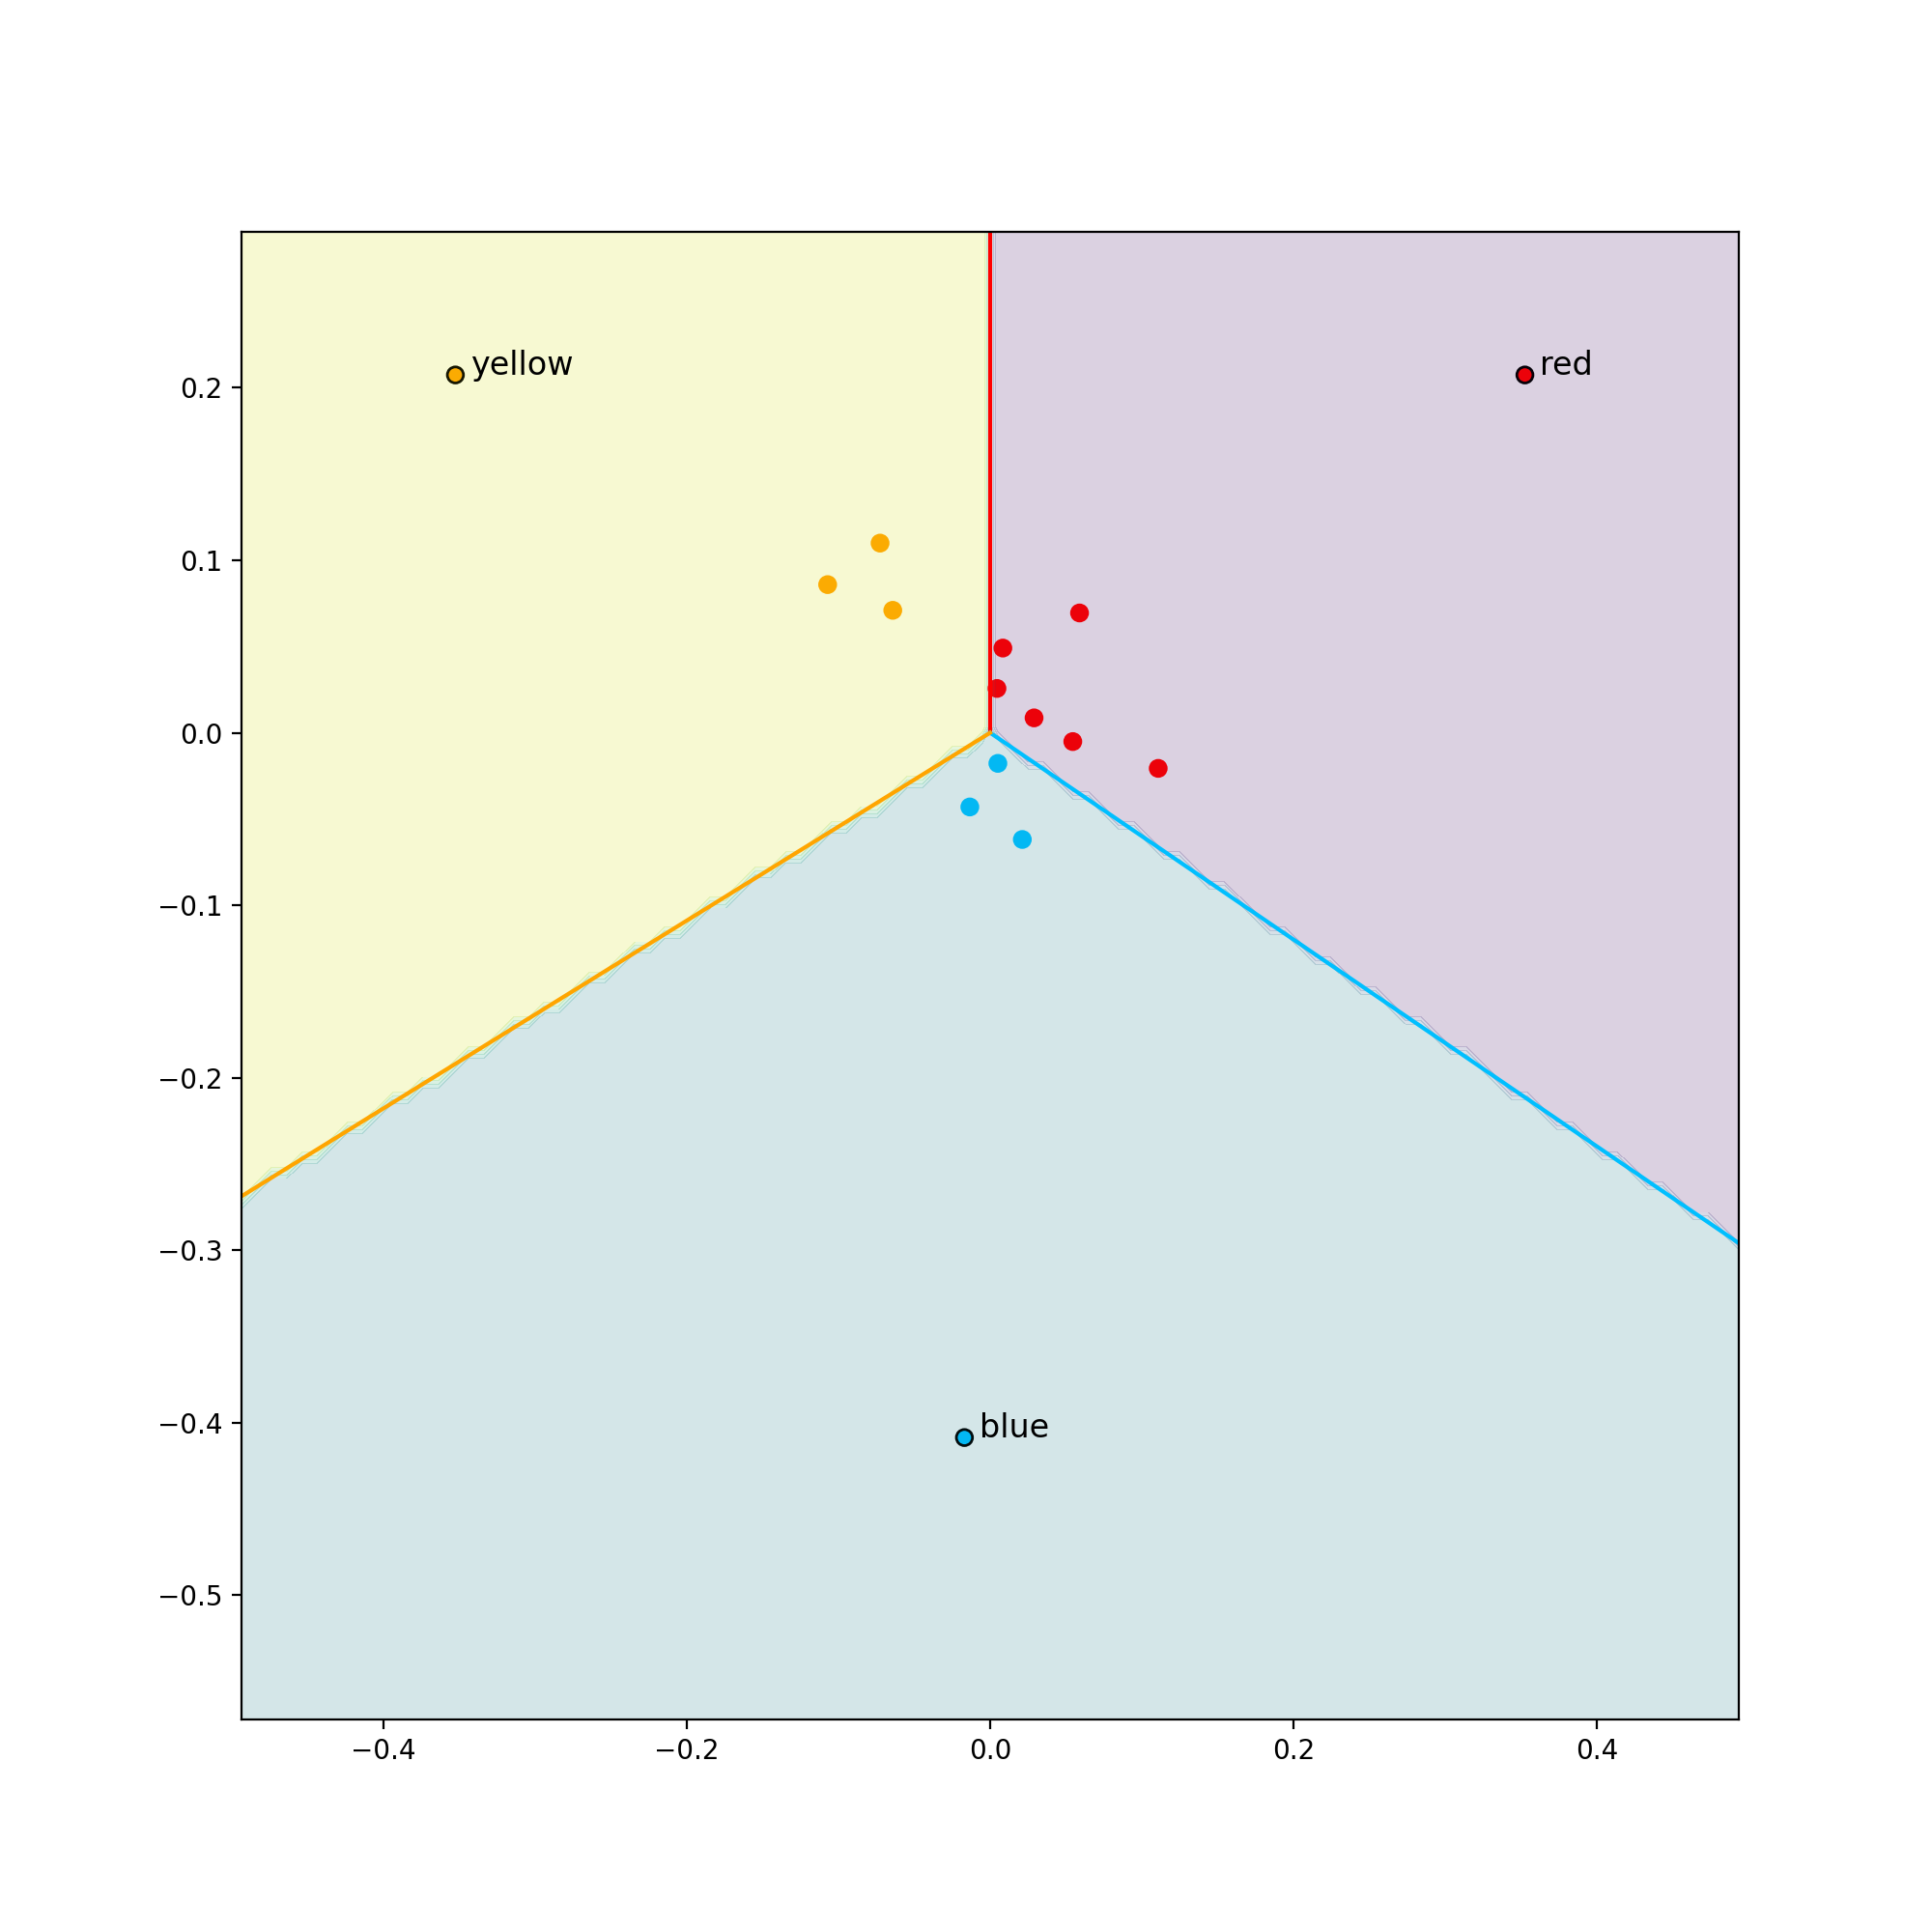

In [22]:
%matplotlib notebook
hover_few_shot_space(reduced_text_features, reduced_image_features_reshaped, images_reshaped, classes,  figsize=(10, 10))